# **Modelling and Evaluation**

## Objectives

* This notebook aims to answer Business Requirement 2:
  * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

We will create a Base model for the prediction, using original image shape and the sigmoid activation function for the output layer. In the next notebook, this model will be adjusted and compared to
1. A model using images with 100 x 100 pixels instead of the original image size
2. A model using images of original image size, but grayscale
3. A model using the softmax activation function for the output layer

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/test
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Saved model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments




---

# Prepare Data Directories

## Import libraries

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/alitapantea/Documents/Projects/mildew-detection-project/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/alitapantea/Documents/Projects/mildew-detection-project'

## Set input directories

In [5]:
data_directory = 'inputs/cherry_leaves_dataset/cherry-leaves/'
train_path = os.path.join(data_directory, 'train')
val_path = os.path.join(data_directory, 'validation')
test_path = os.path.join(data_directory, 'test')

## Set output directory

Next we set our output directory, making sure to add a version number so we can version outputs from different sessions.

In [6]:
version = 1
output_path = f'outputs/v{version}'

if 'outputs' in os.listdir(os.getcwd()) and f'v{version}' in os.listdir(os.path.join(os.getcwd(), 'outputs')):
    print('Version already exists, create a new version')
else:
    os.makedirs(name = output_path)

Version already exists, create a new version


### Set label names

In [9]:
labels = os.listdir(train_path)
print(f'Labels for the images are {labels}')

Labels for the images are ['powdery_mildew', 'healthy']


### Set image shape

We need to import the image shape embedding we previously saved as a .pkl file. 

In [12]:
import joblib
image_shape = joblib.load(filename=f'{output_path}/image_shape.pkl')
image_shape

(256, 256, 3)

---

# Image data assessment and augmentation

## Image data assessment

Let's recap how many images we have in our different sets divided by label:

In [13]:
import os

sets = ['train', 'test', 'validation']
labels = ['healthy', 'powdery_mildew']
for set in sets:
    for label in labels:
        number_of_files = len(os.listdir(f'inputs/cherry_leaves_dataset/cherry-leaves/{set}/{label}'))
        print(f'There are {number_of_files} images in {set}/{label}')

There are 1472 images in train/healthy
There are 1472 images in train/powdery_mildew
There are 422 images in test/healthy
There are 422 images in test/powdery_mildew
There are 210 images in validation/healthy
There are 210 images in validation/powdery_mildew


To help visualize, we add the numbers into a dataframe and create a barplot:

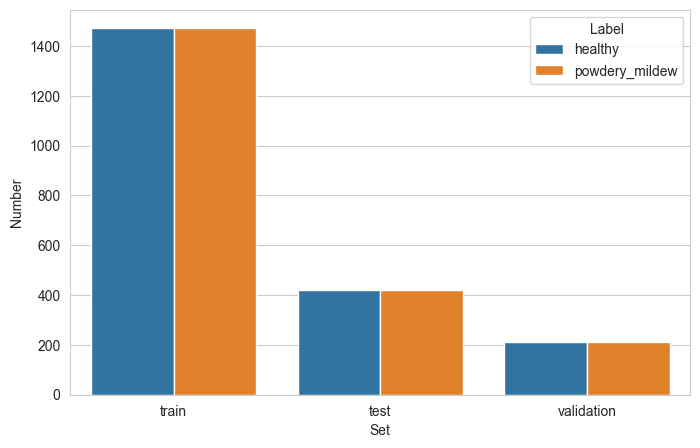

In [14]:
df_images = pd.DataFrame([])
for set in sets:
    for label in labels:
        number_of_files = len(os.listdir(f'inputs/cherry_leaves_dataset/cherry-leaves/{set}/{label}'))
        df_images = df_images.append(
            pd.Series(data={'Set': set,
                            'Label': label,
                            'Number': int(number_of_files)
            }),
            ignore_index=True
        )

sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
sns.barplot(data=df_images, x='Set', y='Number', hue='Label')
plt.savefig(f'{output_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Image Augmentation

In order to have a well-trained model, we ideally want to have larger sets. To achieve this, we can augment our image data using the ImageDataGenerator from the tensorflow keras library. 

The ImageDataGenerator takes the images from the set and performs different operations like rotations, shifts, zooms and flips to effectively create "new" images that are added to the set. 
This way, the new images retain the original features, in our case the leaf shape, color and markings on the leaves, but have small variations in them. 

### Initialize ImagaDataGenerator

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment training image dataset

In [17]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset

In [18]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [19]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training images

We plot some samples from the augmented images to check that we still see the relevant features

(20, 256, 256, 3)


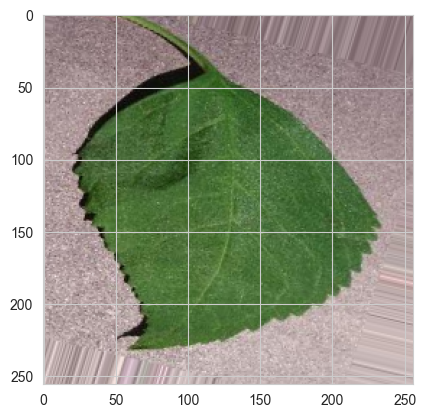

(20, 256, 256, 3)


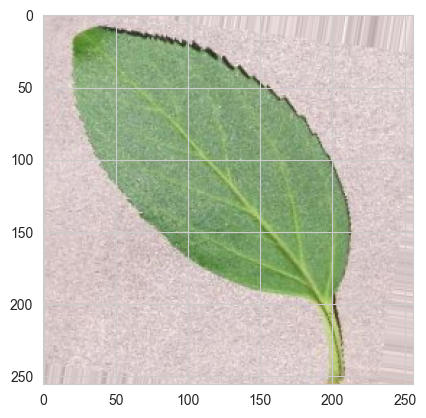

(20, 256, 256, 3)


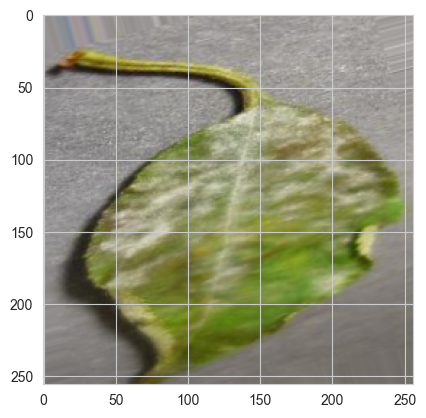

In [25]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot augmented validation and test images

(20, 256, 256, 3)


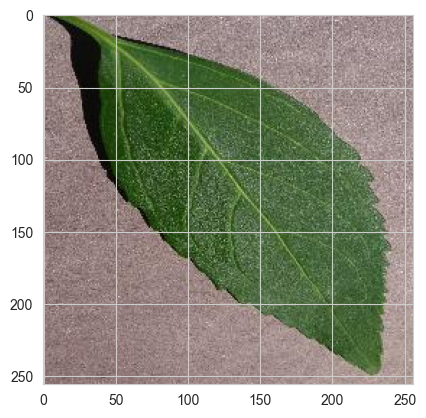

(20, 256, 256, 3)


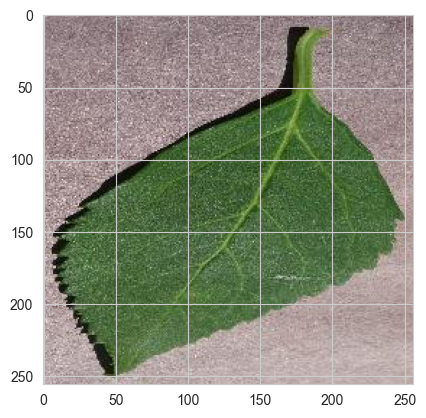

(20, 256, 256, 3)


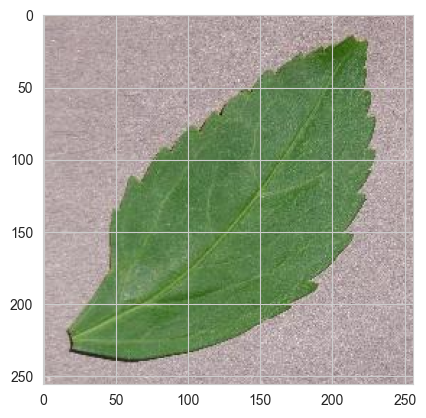

In [24]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


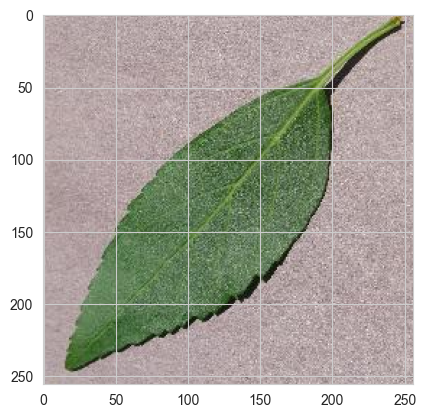

(20, 256, 256, 3)


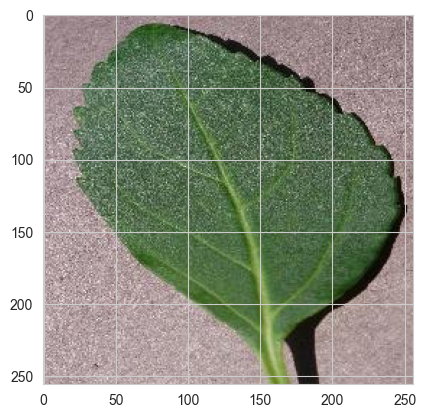

(20, 256, 256, 3)


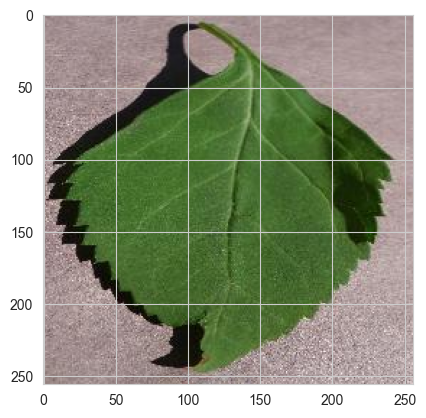

In [22]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save class indices

And we save the class indices as a .pkl file

In [26]:
joblib.dump(value=train_set.class_indices,
            filename=f"{output_path}/class_indices.pkl")


['outputs/v1/class_indices.pkl']

---

# Model creation

## Base ML Model

### Importing model packages

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

As a base ML model, we go with a Convolutional Neural Network, using Tensorflow's Sequential model. 
We will use 

In [83]:

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(2, 2),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(2, 2),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(2, 2),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adagrad',
                  metrics=['accuracy'])

    return model


### Model Summary

In [84]:
create_tf_model().summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 255, 255, 16)      208       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 126, 126, 32)      2080      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 62, 62, 32)        4128      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 30752)           

### Early Stopping

In order to not overfit our model, we add a function to stop the training of the model early.

In [72]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fitting the model for training

In [85]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
147/147 [==============================] - 63s 421ms/step - loss: 0.6595 - accuracy: 0.6149 - val_loss: 0.6041 - val_accuracy: 0.8405
Epoch 2/25
147/147 [==============================] - 61s 417ms/step - loss: 0.5586 - accuracy: 0.7924 - val_loss: 0.4384 - val_accuracy: 0.9095
Epoch 3/25
147/147 [==============================] - 62s 422ms/step - loss: 0.4143 - accuracy: 0.8632 - val_loss: 0.2990 - val_accuracy: 0.9071
Epoch 4/25
147/147 [==============================] - 63s 430ms/step - loss: 0.3271 - accuracy: 0.8844 - val_loss: 0.2335 - val_accuracy: 0.9238
Epoch 5/25
147/147 [==============================] - 61s 417ms/step - loss: 0.2787 - accuracy: 0.9022 - val_loss: 0.1965 - val_accuracy: 0.9405
Epoch 6/25
147/147 [==============================] - 60s 410ms/step - loss: 0.2506 - accuracy: 0.9107 - val_loss: 0.1748 - val_accuracy: 0.9452
Epoch 7/25
147/147 [==============================] - 63s 429ms/step - loss: 0.2281 - accuracy: 0.9189 - val_loss: 0.1509 - val_ac

### Save the model

In [87]:
model.save('outputs/v1/mildew_detector_model.h5')

---

# Model Performance

There are several different ways to assess the performance of our model. 

## Model learning curve

First, we can assess the model learning curve. We look at the loss and accuracy of our train set and validation set. We want the loss to get smaller over the epochs and the accuracy to get higher over the epochs. In an ideal model, the loss of the train set will tend to 0 and the accuracy of the train set will tend to 1, and the loss and accuracy of the validation set will have a very similar progression. 

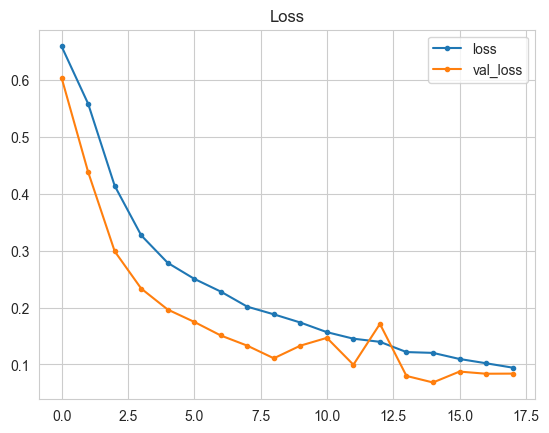

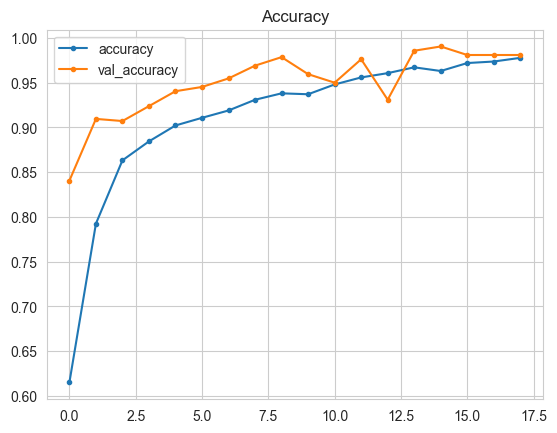

In [86]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{output_path}/model_training_losses11.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{output_path}/model_training_acc11.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Next we can evaluate the absolute loss and accuracy of the model using the keras library and run it on unseen data, i.e. our labelled test set. 

We load the model we saved earlier:

In [90]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.h5')

We evaluate the model on the test set:

In [91]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 3s 71ms/step - loss: 0.0930 - accuracy: 0.9810


We see that the prediction accuracy of the model is at just over 98%, which meets the performance goal set by the client, which was at least 97% accuracy. 

A requirement for a maximum loss was not set.

We save the evaluation as a .pkl file:

In [92]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data

As a manual confirmation, we try if the prediction is accurate on any image we load.

We load any image from our test set (code is adapted and adjusted from the CI Malaria walkthrough):

Image shape: (256, 256), Image mode: RGB


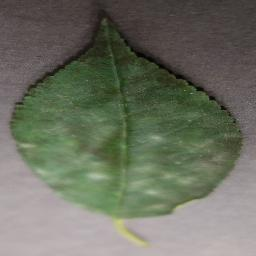

In [107]:
from tensorflow.keras.preprocessing import image

pointer = 35
label = labels[1]  # select healthy or powdery_mildew

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

We need to convert the image to an array using numpy:

In [108]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


And then we predict the class probability:

In [109]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


0.95739174
powdery_mildew


---

# Conclusion and Next Steps

The basic model is meeting business requirement 2: "The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew." The model can reliably predict on unseen images of cherry leaves whether they are healthy or affected by powdery mildew with an accuracy of over 98%. 

The next step is to see if we can improve the model as outlined in the README, by comparing the base with models using smaller images, gray scale images and using a different activation function for the output layer. 